In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_5324.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_3382.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_1398.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_1142.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_5002.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_2646.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_3476.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_1613.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_5593.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_2975.BMP
/kaggle/input/finger-print-based-blood-g

In [8]:


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from collections import Counter
import numpy as np
import shutil
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import load_img,img_to_array,save_img


In [9]:
BATCH_SIZE=32

In [10]:
import kagglehub
import os
# Download latest version
dataset_path = kagglehub.dataset_download("rajumavinmar/finger-print-based-blood-group-dataset")

print("Path to dataset files:", dataset_path)



print("Classes found:", os.listdir(dataset_path))


Path to dataset files: /kaggle/input/finger-print-based-blood-group-dataset
Classes found: ['dataset_blood_group']


In [11]:
dataset_path = "/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group"

dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=(64, 64),
    batch_size=BATCH_SIZE,
    shuffle=True
)


Found 6000 files belonging to 8 classes.


In [12]:
class_names=dataset.class_names
class_counts=Counter()
for _,labels in dataset.unbatch():
    class_counts[int(labels.numpy())]+=1
print("Class Distribution:")

for i,count in class_counts.items():
    print(f"{class_names[i]}:{count}")

Class Distribution:
O-:712
A-:1009
AB-:761
B+:652
B-:741
O+:852
A+:565
AB+:708


In [13]:
import matplotlib.pyplot as plt
def plot_class_distribution(class_names,class_counts):
    classes = [class_names[i] for i  in class_counts.keys()]
    counts=[class_counts[i] for i in class_counts.keys()]

    plt.figure(figsize=(10,6))

In [14]:
import matplotlib.pyplot as plt

def plot_class_distribution(class_names, class_counts):
    # Assuming class_counts is a dict like {'cat': 500, 'dog': 800, ...}
    classes = [class_names[i] for i in class_counts.keys()]  # if class_names is a list
    counts = [class_counts[i] for i in class_counts.keys()]

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Class Names')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


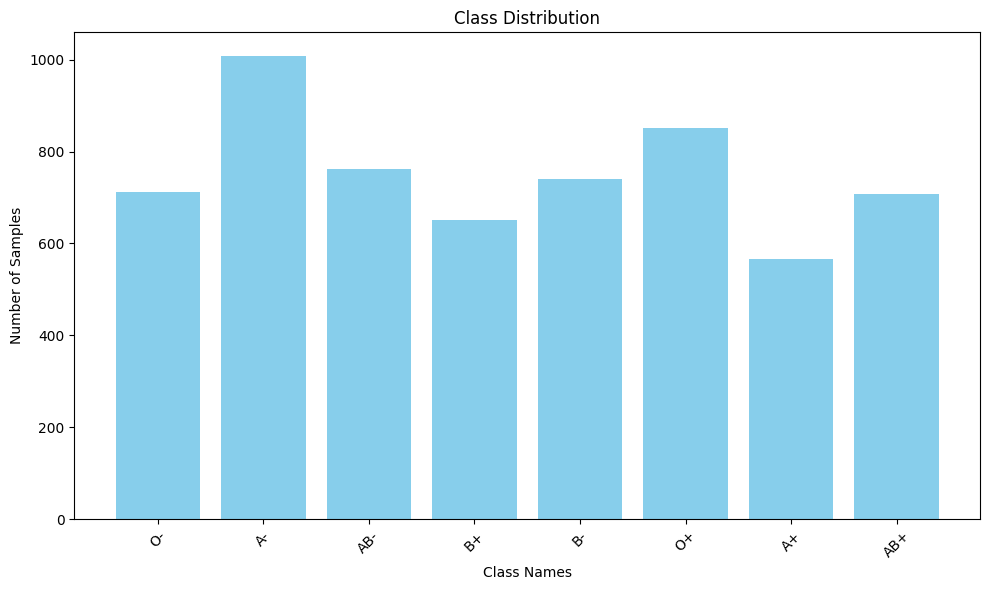

In [15]:
plot_class_distribution(class_names,class_counts)

In [16]:
max_count=max(class_counts.values())
print(max_count)

1009


In [17]:
def oversample_class(class_id,count,max_count):
    unbatched_dataset=dataset.unbatch()
    class_dataset=unbatched_dataset.filter(lambda img,lbl:tf.equal(lbl,class_id))
    repeat_factor=max_count// count+(max_count % count >0)
    return class_dataset.repeat(repeat_factor).take(max_count)

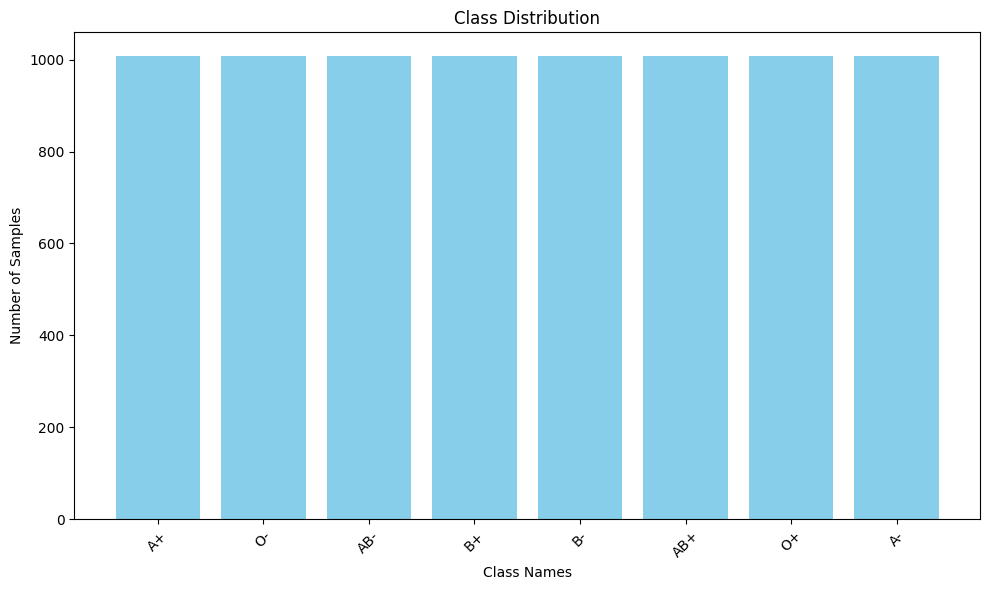

In [18]:
balanced_datasets=[]
for class_id,count in class_counts.items():
    balanced_datasets.append(oversample_class(class_id,count,max_count))
balanced_dataset=tf.data.Dataset.sample_from_datasets(balanced_datasets)

balanced_class_counts=Counter([int(lbl.numpy()) for _,lbl in balanced_dataset])
plot_class_distribution(class_names,balanced_class_counts)
balanced_dataset=balanced_dataset.batch(BATCH_SIZE,drop_remainder=True)

In [19]:
for sample in balanced_dataset.take(10):
    print(sample[0].shape)

(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)


In [20]:
balanced_dataset_unbatched=balanced_dataset.unbatch()
dataset_size=sum(1 for _ in balanced_dataset_unbatched)
print(f"Total dataset size: {dataset_size}") 

Total dataset size: 8064


In [21]:
balanced_dataset_unbatched=balanced_dataset.unbatch()
train_ratio=0.7
val_ratio=0.2
test_ratio=0.1

train_size=int(train_ratio * dataset_size)
val_size=int(val_ratio * dataset_size)

train_dataset=balanced_dataset_unbatched.take(train_size)
val_test_dataset=balanced_dataset_unbatched.skip(train_size)
val_dataset=val_test_dataset.take(val_size)
test_dataset=val_test_dataset.skip(val_size)

train_dataset=train_dataset.batch(BATCH_SIZE,drop_remainder=True)
val_dataset=val_dataset.batch(BATCH_SIZE,drop_remainder=True)
test_dataset=test_dataset.batch(BATCH_SIZE,drop_remainder=True)


train_batch_count=sum(1 for _ in train_dataset)
val_batch_count=sum(1 for _ in val_dataset)
test_batch_count=sum(1 for _ in test_dataset)

print(f"TRAINING dataset size:{train_batch_count * BATCH_SIZE}")
print(f"VALIDATION dataset size:{val_batch_count * BATCH_SIZE}")
print(f"TESTING dataset size:{test_batch_count * BATCH_SIZE}")

TRAINING dataset size:5632
VALIDATION dataset size:1600
TESTING dataset size:800


In [22]:
def create_high_accuracy_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

high_accuracy_model = create_high_accuracy_model()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # fixed underscore
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)


In [24]:

history_high_acc = high_accuracy_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50, 
    callbacks=[reduce_lr, early_stop]
)


Epoch 1/50
    176/Unknown 49s 262ms/step - accuracy: 0.1301 - loss: 37.3018

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


176/176 ━━━━━━━━━━━━━━━━━━━━ 64s 350ms/step - accuracy: 0.1301 - loss: 37.1466 - val_accuracy: 0.1281 - val_loss: 2.0380 - learning_rate: 0.0010
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 62s 348ms/step - accuracy: 0.1877 - loss: 2.0151 - val_accuracy: 0.5502 - val_loss: 1.4709 - learning_rate: 0.0010
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 62s 350ms/step - accuracy: 0.4553 - loss: 1.4283 - val_accuracy: 0.6924 - val_loss: 1.2311 - learning_rate: 0.0010
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 61s 346ms/step - accuracy: 0.5906 - loss: 1.1150 - val_accuracy: 0.7457 - val_loss: 1.0665 - learning_rate: 0.0010
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 61s 348ms/step - accuracy: 0.6567 - loss: 0.9528 - val_accuracy: 0.7310 - val_loss: 1.0323 - learning_rate: 0.0010
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 62s 349ms/step - accuracy: 0.6890 - loss: 0.8524 - val_accuracy: 0.7953 - val_loss: 1.0153 - learning_rate: 0.0010
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 63s 354ms/step - accuracy: 0.7188 - loss

In [25]:
high_acc_eval = high_accuracy_model.evaluate(val_dataset)
print(f"High Accuracy Model - Loss: {high_acc_eval[0]}, Accuracy: {high_acc_eval[1]}")


50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - accuracy: 0.9391 - loss: 0.3085
High Accuracy Model - Loss: 0.2998031973838806, Accuracy: 0.9227941036224365


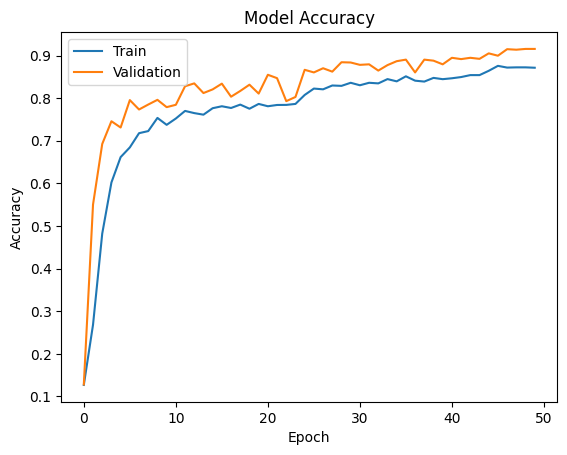

In [28]:
import matplotlib.pyplot as plt 

def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')  # Corrected here
    plt.show()

plot_accuracy(history_high_acc)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Classification Report:
              precision   

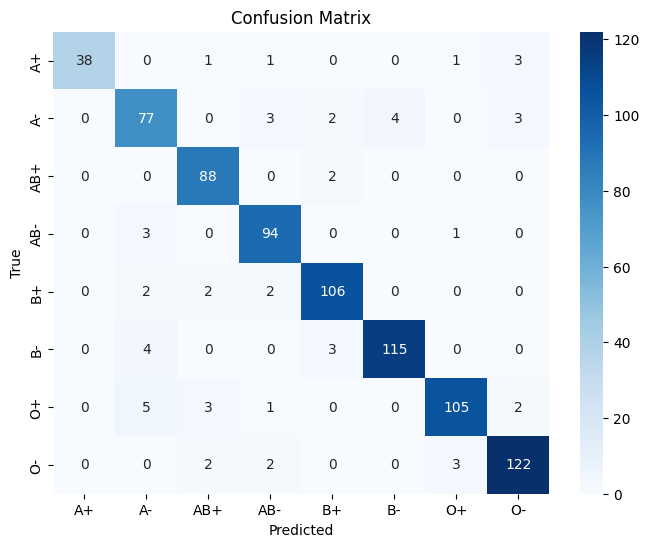

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = high_accuracy_model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [30]:
high_accuracy_model.save('model.h5')
print("Model saved as HDF5 format")


Model saved as HDF5 format


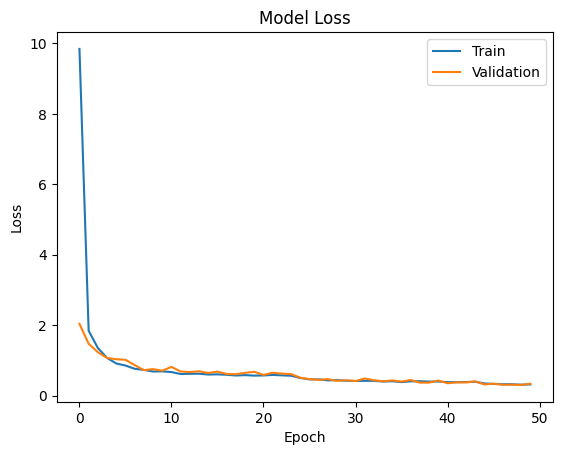

In [31]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

plot_loss(history_high_acc)


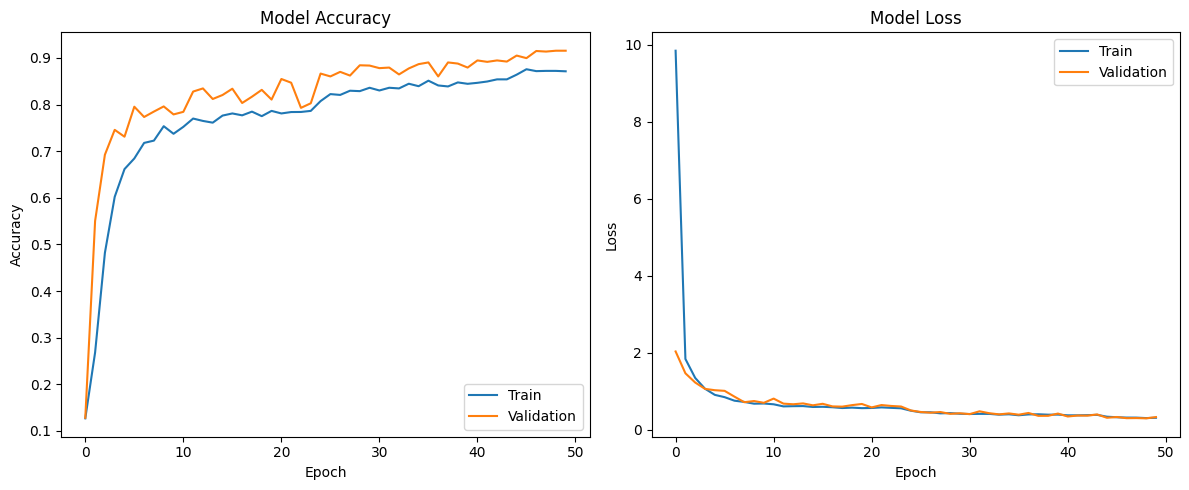

In [32]:
def plot_accuracy_and_loss(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(['Train', 'Validation'], loc='lower right')

    # Loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

plot_accuracy_and_loss(history_high_acc)


25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


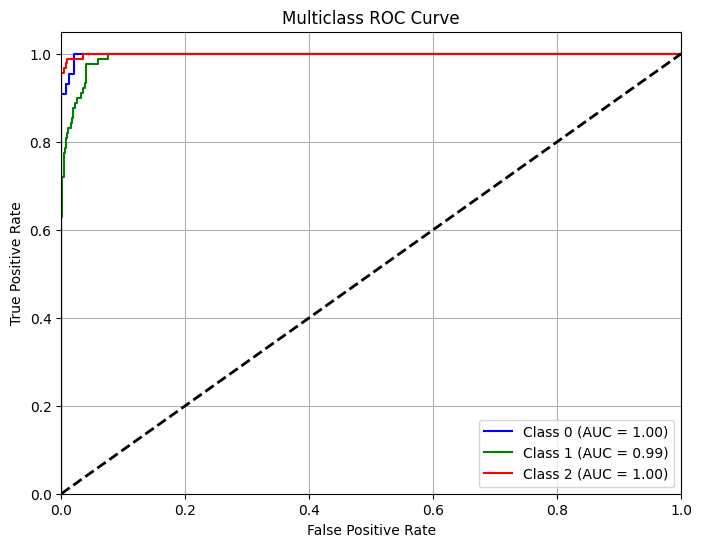

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Let's say you have 3 classes
n_classes = 3

# y_true: true labels (e.g. [0, 2, 1, 0, ...])
# Convert to one-hot
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

# Get predicted probabilities
y_score = high_accuracy_model.predict(test_dataset)

# Compute ROC and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i],
             label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
